In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import os
from groq import Groq
import pandas as pd
import numpy as np
import os
import json
import time
import string
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
client = Groq(
    api_key="access_token",
)

In [ ]:
def batch_gpt(message_prompt):
    rez = {}
    responses = []
    response = client.chat.completions.create(
                  messages=[
                      {
                          "role": "user",
                          "content": message_prompt,
                      }
                  ],
                  model="gemma2-9b-it",
              )
    r = response.choices[0].message.content
    responses.append(r)

    return r, responses

In [ ]:
def get_mess():
  mess = """
You need to find the existing discourse relations between 2 elementary discourse units. Discourse relations between 2 discourse units can be explicit or implicit.
I will give you a text and 2 elementary discourse units extracted from that text and then i will provide you with all the 12 possible discourse relation types from which you should choose one. In the context of the example discourse units, discourse_unit_1 comes before discourse_unit_2. From the give relaions_types you should  determine the type of existing discourse relation between 2 given example elementary discourse units.
Return the result in json format  with no addition explanation:
example:
{"discourse_relation" : "found_discourse_relation"}
      """

  return mess

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/chat_gpt_datasets/eng.dep.covdtb_test.rels.csv', sep='\t')
df = pd.DataFrame(columns=['EDU_1', 'EDU_2', 'Real discourse relation', 'Gamma discourse relation'])
unprocessed_data = pd.DataFrame(columns=['unit1_sent', 'unit2_sent', 'dir', 'label'])
dataset.shape

(2586, 12)

In [ ]:
dataset.head(1)

,doc,unit1_toks,unit2_toks,unit1_txt,unit2_txt,s1_toks,s2_toks,unit1_sent,unit2_sent,dir,orig_label,label
0,00c862a6402381a8541bcffe843696e059095300,1-18,19-22,"In this study , we investigated turkey reoviru...",aged 15 days .,1-22,1-22,"In this study , we investigated turkey reoviru...","In this study , we investigated turkey reoviru...",1<2,elaboration,elaboration


In [ ]:
data_with_texts = pd.read_csv('/content/drive/MyDrive/chat_gpt_datasets/files for prediction/eng_dep_covdtb_texts_test.csv')
data_with_texts.head()

,Document ID,Document Abstract
0,00c862a6402381a8541bcffe843696e059095300,"In this study , we investigated turkey reoviru..."
1,0146a0b36f80ebcb868c7e16fb60c1a9d2afbf83,This is an extensive review on epiphytic plant...
2,0232f18e7bbf3192e9e34da1c0abe2a20b2ba1e4,"Herein , the LASSBio Chemical Library is prese..."
3,09bdbea1700a3826acc33484ed51e2fa8c23f047,Data - centric models of COVID-19 have been tr...
4,0b362bc7e9278b56c2740ab7bc10e91c036f835a,We study seasonal epidemic spreading in a susc...


In [ ]:
message_part1 = get_mess()
message_part2 = {
      'elaboration',
      'findings',
      'joint',
      'attribution',
      'manner-means',
      'enablement',
      'cause-result',
      'background',
      'comparison',
      'textual-organization',
      'temporal',
      'condition'
  }

for i in range(0, len(dataset)):
  print()
  doc_id = dataset['doc'][i]
  sentence_1 = dataset['unit1_txt'][i]
  sentence_2 = dataset['unit2_txt'][i]
  real_label = dataset['label'][i]

  row = data_with_texts[data_with_texts['Document ID'] == doc_id]
  document_text = row['Document Abstract'].values[0]

  message_part3 = {
      "text" : document_text
  }

  message_part4 = {
        "discourse_unit_1" : sentence_1,
        "discourse_unit_2" : sentence_2
  }

  prompt_message = message_part1 + '\n' + 'relation_types = ' + str(message_part2) + '\n' + '\nexample_text = ' + str(message_part3) + '\n' + '\nexample_discourse_units = ' + str(message_part4)
  print(str(i) + " " + str(message_part4))
  try:
    result, response = batch_gpt(prompt_message)
    result = result.replace('json', '')
    result = result.replace('`', '')
    result = result.strip()
    print(result)
    json_result = json.loads(result)
    gpt_relation = json_result['discourse_relation']
  except Exception as e:
    print("ERROR")
    print(e)
    unprocessed_data.loc[len(unprocessed_data)] = {'unit1_txt': dataset['unit1_txt'][i], 'unit2_txt': dataset['unit2_txt'][i], 'dir': dataset['dir'][i], 'label': real_label}
  else:
    new_row = {'EDU_1': sentence_1, 'EDU_2': sentence_2, 'Real discourse relation': real_label, 'Gamma discourse relation': gpt_relation}
    df.loc[len(df)] = new_row
    if i % 30 == 0:
      time.sleep(60)

In [ ]:
df.to_csv('path_to_save/gemma_eng_dep_covdtb_test_results.csv', index=False)

# RESULTS

In [ ]:
relation_results = df

In [ ]:
print(relation_results.shape)

(2584, 4)


In [ ]:
relation_results.head(1)

,EDU_1,EDU_2,Real discourse relation,Gamma discourse relation
0,"In this study , we investigated turkey reoviru...",aged 15 days .,elaboration,temporal


In [ ]:
print("Accuracy score = " + str(accuracy_score(relation_results['Real discourse relation'].astype(str), relation_results['Gamma discourse relation'].astype(str))))

Accuracy score = 0.33900928792569657


In [ ]:
f1 = f1_score(relation_results['Real discourse relation'].astype(str),  relation_results['Gamma discourse relation'].astype(str), average='macro')
print("F1 score = " + str(f1))

F1 score = 0.048115697699915715


In [ ]:
all_relations = relation_results['Real discourse relation'].unique()
for rel in all_relations:
  filtered_df = relation_results[relation_results['Real discourse relation'] == rel]
  print("Accuracy score for relation " + str(rel) + " = " + str(accuracy_score(filtered_df['Real discourse relation'].astype(str), filtered_df['Gamma discourse relation'].astype(str))))

Accuracy score for relation elaboration = 0.45987654320987653
Accuracy score for relation findings = 0.026143790849673203
Accuracy score for relation joint = 0.1206896551724138
Accuracy score for relation attribution = 0.009708737864077669
Accuracy score for relation manner-means = 0.4260869565217391
Accuracy score for relation enablement = 0.03619909502262444
Accuracy score for relation cause-result = 0.6296296296296297
Accuracy score for relation background = 0.5227272727272727
Accuracy score for relation comparison = 0.1111111111111111
Accuracy score for relation textual-organization = 0.16363636363636364
Accuracy score for relation temporal = 0.12
Accuracy score for relation condition = 0.6363636363636364


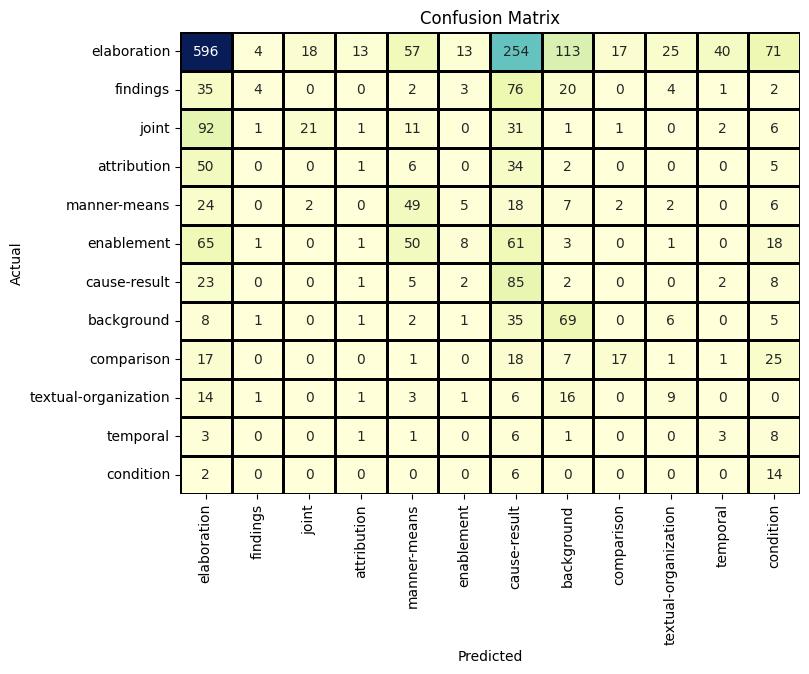

In [ ]:
conf_matrix = confusion_matrix(relation_results["Real discourse relation"].astype(str), relation_results["Gamma discourse relation"].astype(str), labels=all_relations)
confusion_df = pd.DataFrame(conf_matrix, index=all_relations, columns=all_relations)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor="black", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.savefig("/content/confusion_matrix_gemma_covdtb_all_relations.png", dpi=600, bbox_inches='tight')

plt.show()